In [1]:
import pandas as pd

# Load CSV
file_path = 'tickets.csv'
df = pd.read_csv(file_path)

# Display basic information
print(df.head())
print(df.info())

df = df.sample(n=3000, random_state=42).reset_index(drop=True)

# Display dataset shape
print(f"Trimmed dataset size: {df.shape}")

                                            Document    Topic_group
0  connection with icon icon dear please setup ic...       Hardware
1  work experience user work experience user hi w...         Access
2  requesting for meeting requesting meeting hi p...       Hardware
3  reset passwords for external accounts re expir...         Access
4  mail verification warning hi has got attached ...  Miscellaneous
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47837 entries, 0 to 47836
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Document     47837 non-null  object
 1   Topic_group  47837 non-null  object
dtypes: object(2)
memory usage: 747.6+ KB
None
Trimmed dataset size: (3000, 2)


In [2]:
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch

# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
print(df['Topic_group'].unique())
# Encode labels
label_encoder = LabelEncoder()
df['encoded_labels'] = label_encoder.fit_transform(df['Topic_group'])
print(df.head())
# Tokenize function for the dataset
def tokenize_data(texts, labels, max_length=128):
    encodings = tokenizer(
        texts,
        truncation=True,
        padding='max_length',  # Ensure uniform input size
        max_length=max_length,
        return_tensors="pt"  # Return PyTorch tensors directly
    )
    labels = torch.tensor(labels, dtype=torch.long)  # Ensure labels are of type 'long'
    return encodings, labels

# Example: Assuming 'Document' is the text column and 'encoded_labels' is the numerical label
texts = df['Document'].tolist()
labels = df['encoded_labels'].tolist()

# Train/test split (80/20)
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

# Tokenize data
train_encodings, train_labels = tokenize_data(train_texts, train_labels)
val_encodings, val_labels = tokenize_data(val_texts, val_labels)

/Users/raphaelloscher/.pyenv/versions/3.9.13/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/raphaelloscher/.pyenv/versions/3.9.13/lib/python3.9/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


['Hardware' 'Purchase' 'HR Support' 'Access' 'Internal Project'
 'Administrative rights' 'Miscellaneous' 'Storage']
                                            Document Topic_group  \
0  issue with server process sent tuesday issue w...    Hardware   
1  new purchase po wednesday february purchase po...    Purchase   
2  oracle pas urgent re we updated rights query h...    Hardware   
3  new starter access thursday pm re starter form...  HR Support   
4  new phone phone hi taken work mobile phone spe...    Hardware   

   encoded_labels  
0               3  
1               6  
2               3  
3               2  
4               3  


In [3]:
from torch.utils.data import Dataset

class IncidentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

# Create Dataset objects
train_dataset = IncidentDataset(train_encodings, train_labels)
val_dataset = IncidentDataset(val_encodings, val_labels)

In [6]:
from transformers import Trainer, TrainingArguments, BertForSequenceClassification

# Load pre-trained BERT for classification
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(set(labels)))

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    logging_dir='./logs',
    logging_steps=10,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# Start Training
trainer.train()

/Users/raphaelloscher/.pyenv/versions/3.9.13/lib/python3.9/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/5_/tz18hjw14f99tbtqv0469f_00000gn/T/ipykernel_39807/79753804.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss
1,0.891700,0.866674
2,0.522400,0.660740
3,0.481900,0.792640
4,0.210000,1.220820
5,0.141400,1.200198
6,0.027900,1.229284
7,0.021400,1.252621
8,0.000500,1.454139
9,0.007300,1.341754
10,0.000400,1.351594


Checkpoint destination directory ./results/checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/var/folders/5_/tz18hjw14f99tbtqv0469f_00000gn/T/ipykernel_39807/79753804.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Checkpoint destination directory ./results/checkpoint-1000 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/var/folders/5_/tz18hjw14f99tbtqv0469f_00000gn/T/ipykernel_39807/79753804.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C

TrainOutput(global_step=3000, training_loss=0.2904894298925064, metrics={'train_runtime': 1621.2127, 'train_samples_per_second': 14.804, 'train_steps_per_second': 1.85, 'total_flos': 1578751377408000.0, 'train_loss': 0.2904894298925064, 'epoch': 10.0})

In [7]:
trainer.evaluate()

/var/folders/5_/tz18hjw14f99tbtqv0469f_00000gn/T/ipykernel_39807/79753804.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'eval_loss': 1.3515942096710205,
 'eval_runtime': 8.038,
 'eval_samples_per_second': 74.645,
 'eval_steps_per_second': 9.331,
 'epoch': 10.0}

In [8]:
model.save_pretrained("./bert-incident-classifier")
tokenizer.save_pretrained("./bert-incident-classifier")

('./bert-incident-classifier/tokenizer_config.json',
 './bert-incident-classifier/special_tokens_map.json',
 './bert-incident-classifier/vocab.txt',
 './bert-incident-classifier/added_tokens.json')

In [9]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# Load model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(set(labels))  # Match number of classes
)

# Move model to MPS (or fallback to CPU)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

def classify_text(text):
    # Tokenize input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    inputs = {key: val.to(device) for key, val in inputs.items()}  # Move inputs to the model's device
    
    # Run model and predict
    outputs = model(**inputs)
    prediction = torch.argmax(outputs.logits, dim=1)
    return prediction.item()

# Test with a sample text
sample_text = "As a user, I cannot access the application."
print(f"Predicted category: {classify_text(sample_text)}")

/Users/raphaelloscher/.pyenv/versions/3.9.13/lib/python3.9/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Predicted category: 5


In [10]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = BertForSequenceClassification.from_pretrained("./bert-incident-classifier")
tokenizer = BertTokenizer.from_pretrained("./bert-incident-classifier")
model.to(device)
model.eval()
print(model.config.num_labels)
print(model.config)


8
BertConfig {
  "_name_or_path": "./bert-incident-classifier",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transform

/var/folders/5_/tz18hjw14f99tbtqv0469f_00000gn/T/ipykernel_39807/79753804.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


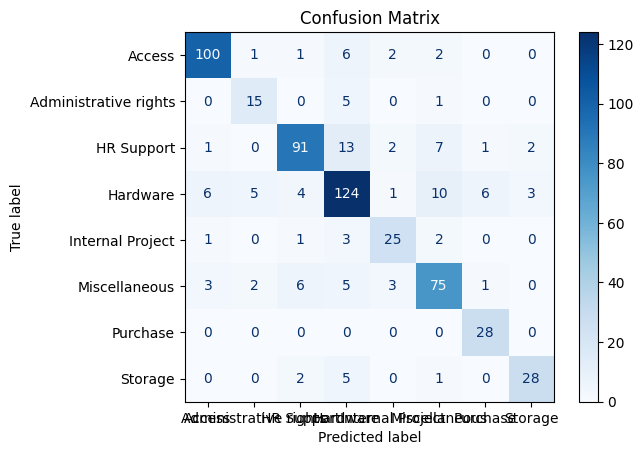

                       precision    recall  f1-score   support

               Access       0.90      0.89      0.90       112
Administrative rights       0.65      0.71      0.68        21
           HR Support       0.87      0.78      0.82       117
             Hardware       0.77      0.78      0.78       159
     Internal Project       0.76      0.78      0.77        32
        Miscellaneous       0.77      0.79      0.78        95
             Purchase       0.78      1.00      0.88        28
              Storage       0.85      0.78      0.81        36

             accuracy                           0.81       600
            macro avg       0.79      0.81      0.80       600
         weighted avg       0.81      0.81      0.81       600



In [14]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

# Create DataLoader for validation dataset
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Get predictions and true labels
def get_predictions_and_labels(model, dataloader):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in dataloader:
            batch = {key: val.to(device) for key, val in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(batch['labels'].cpu().numpy())

    return predictions, true_labels

# Get predictions and labels
y_pred, y_true = get_predictions_and_labels(model, val_loader)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualize confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true, y_pred, target_names=list(label_encoder.classes_)))